In [1]:
%%capture
%run preprocessing.ipynb

In [2]:
# Affiche les variables et modules importés depuis le notebook preprocessing.ipynb
%whos

Variable   Type         Data/Info
---------------------------------
flipkart   DataFrame                             <...>\n[1050 rows x 4 columns]
gc         module       <module 'gc' (built-in)>
msno       module       <module 'missingno' from <...>\missingno\\__init__.py'>
os         module       <module 'os' (frozen)>
pd         module       <module 'pandas' from 'c:<...>es\\pandas\\__init__.py'>
plt        module       <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>


In [ ]:
# Autres imports

# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [4]:
flipkart = globals()['flipkart']
print(flipkart.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  1050 non-null   object
 1   image         1050 non-null   object
 2   description   1050 non-null   object
 3   class         1050 non-null   object
dtypes: object(4)
memory usage: 32.9+ KB
None


## EDA sur le texte

Avant d'étudier le texte, je vais procéder à léger nettoyage de valeurs textuelles abbérantes :
- Ajout d'un espace après un point qui 

In [ ]:
# Define a pattern to capture every word with a point inside
pattern = r"\w+\.\w+"

# Find and display the words that match the pattern in the description column
flipkart_filtered["description"].str.findall(pattern).apply(len).value_counts()

description
0     334
1     331
2     259
3      88
5       8
4       8
6       7
18      6
8       4
9       2
7       1
10      1
11      1
Name: count, dtype: int64

In [ ]:
# Define a pattern to match urls in the description column
pattern = r"www\.\S+"

# Find and display the urls that match the pattern in the description column
flipkart_filtered["description"].str.findall(pattern).apply(len).value_counts()

description
0    1050
Name: count, dtype: int64

In [ ]:
# Define an email pattern to match emails in the description column
pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"

# Find and display the emails that match the pattern in the description column
flipkart_filtered["description"].str.findall(pattern).apply(len).value_counts()

description
0    1049
1       1
Name: count, dtype: int64

In [ ]:
# Define a pattern to capture the phone numbers in the description column
pattern = r"\b\d{10}\b"

# Find and display the phone numbers that match the pattern in the description column
flipkart_filtered["description"].str.findall(pattern).apply(len).value_counts()

description
0    1050
Name: count, dtype: int64

## Identification des erreurs d'encodage dans les colonnes textes

J'ai identifié un problème d'encodage dans les colonnes textuelles avec le caractère �.<br>
Regardons les colonnes textuelles pour vérifier la présence de ce caractère.

In [ ]:
# Define the problematic pattern
pattern = "�"

# Check if the flipkart_filtered DataFrame contains the character �
flipkart_filtered.select_dtypes(include="object").apply(
    lambda x: x.str.count(pattern).sum()
)

uniq_id                    0.0
image                      0.0
product_name               3.0
category_0                 0.0
category_1                 0.0
category_2                 0.0
category_3                 0.0
category_4                 1.0
category_5                 0.0
category_6                 0.0
description               11.0
product_specifications     4.0
dtype: float64

In [ ]:
# Create a new list
words = []
non_words = []

# Create a pattern to match words containing the character � with a pattern like "___" which doesn't exist in the text
word_pattern = r"\b\w*___\w*\b"
nonword_pattern = r"\b\W*___\W*\b"

# Add each word with word_pattern to the words list and each word with nonword_pattern to the non_words list
for column in flipkart_filtered.select_dtypes(include="object").replace("�", "___"):
    words.append(
        (
            column,
            flipkart_filtered[column]
            .dropna()
            .str.replace("�", "___")
            .str.findall(word_pattern)
            .sum(),
        )
    )
    non_words.append(
        (
            column,
            flipkart_filtered[column]
            .dropna()
            .str.replace("�", "___")
            .str.findall(nonword_pattern)
            .sum(),
        )
    )

# Print the words and non_words lists
print(words)
print(non_words)

[('uniq_id', []), ('image', []), ('product_name', ['Repouss______', '___']), ('category_0', []), ('category_1', []), ('category_2', []), ('category_3', []), ('category_4', ['___']), ('category_5', []), ('category_6', []), ('description', ['Repouss______', 'Repouss______', '___To', '___', '___To', '___', '___', 'd___cor', 'd___cor']), ('product_specifications', ['Repouss______', 'Repouss______'])]
[('uniq_id', []), ('image', []), ('product_name', [' ___ ']), ('category_0', []), ('category_1', []), ('category_2', []), ('category_3', []), ('category_4', [' ___ ']), ('category_5', []), ('category_6', []), ('description', ['.___\r\n', '.___', ' ___ ']), ('product_specifications', [])]


Après inspection des passages concernée, je peux remplacer les passages spécifiques avec "Repouss��" et "d�cor" par "Repousse" et "decor" respectivement.<br>
Pour le reste, je vais supprimer les occurences de ce caractère.

In [ ]:
# Define the pattern to match
pattern_1 = "Repouss��"
pattern_2 = "d�cor"

# Replace the pattern_1 by "Repoussé" and the pattern_2 by "décor" in the product_specifications column
for column in flipkart_filtered.select_dtypes(include="object"):
    flipkart_filtered[column] = (
        flipkart_filtered[column]
        .str.replace(pattern_1, "Repoussé")
        .str.replace(pattern_2, "décor")
        .str.replace(pattern, "")
    )

# Check if the flipkart_filtered DataFrame contains the character �
assert (
    flipkart_filtered.select_dtypes(include="object")
    .apply(lambda x: x.str.count(pattern).sum())
    .sum()
    == 0.0
), "Il reste encore des caractères � dans le DataFrame"

In [ ]:
# Concatenante the product_name and description columns
flipkart_filtered["text"] = (
    flipkart_filtered["product_name"] + " " + flipkart_filtered["description"]
)

Nous allons étudier parmi les deux colonnes plusieurs statistiques descriptives pour mieux comprendre leur composition et leur distribution.<br>
Pour faciliter la tâche, je vais utiliser Spacy pour tokeniser les colonnes 'product_name', 'description' et `text` puis réaliser l'étude des tokens.<br>
Concernant le modèle, je vais utiliser le modèle 'en_core_web_trf' pour sa performance sur la lemmatisation.

In [ ]:
# Load the en_core_web_trf model
trf = spacy.load("en_core_web_trf")

# Display the pipeline components into the trf
print("Liste des composantes du pipeline:")
print(trf.pipe_names)

Liste des composantes du pipeline:
['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


Seul le NER n'a aucun impact sur la qualité de la lemmatisation donc nous le désactivons :

In [ ]:
# Deactivate the NER component
print("Composante désactivée: ", trf.disable_pipes("ner"))

Composante désactivée:  ['ner']


In [ ]:
# Define a list with our 3 columns
options = ["product_name", "description", "text"]

In [ ]:
for option in options:
    # Create a doc object for each column in the options list
    flipkart_filtered[option + "_nb_tokens"] = [
        len(doc) for doc in flipkart_filtered[option].str.split()
    ]

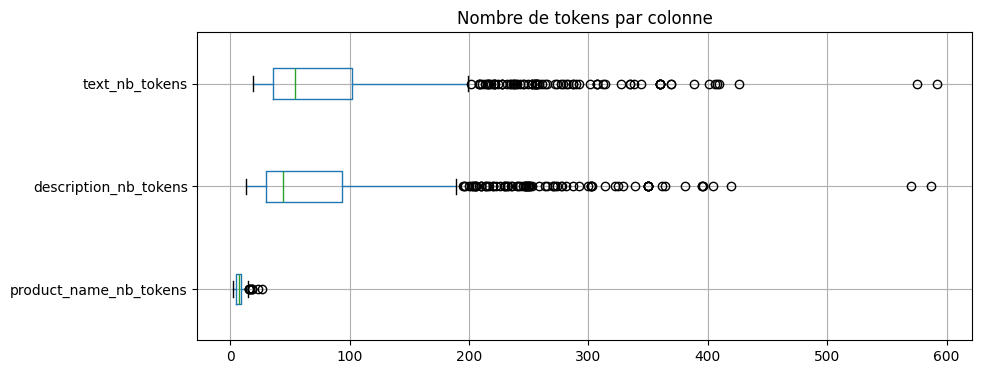

In [ ]:
flipkart_filtered.boxplot(
    column=["product_name_nb_tokens", "description_nb_tokens", "text_nb_tokens"],
    vert=False,
    figsize=(10, 4),
).set(title="Nombre de tokens par colonne")
plt.show()

In [ ]:
flipkart_filtered[
    ["product_name_nb_tokens", "description_nb_tokens", "text_nb_tokens"]
].describe()

,product_name_nb_tokens,description_nb_tokens,text_nb_tokens
count,1050.000000,1050.000000,1050.000000
mean,7.266667,76.201905,83.468571
std,2.890656,74.850937,75.194260
min,2.000000,13.000000,19.000000
25%,5.000000,30.000000,36.000000
50%,7.000000,44.000000,54.000000
75%,9.000000,94.000000,102.000000
max,27.000000,587.000000,592.000000


In [ ]:
# Création d'un dictionnaire raw_vocab